In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn import svm,cluster
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
import six
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier as DT
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')


## 1. Reading data into a pandas dataframe

In [2]:
stroke_data = pd.read_csv("healthcare-dataset-stroke-data.csv")

## 2. Exploratory analysis

In [3]:
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 2.1 Decriptive analysis of features

In [4]:
stroke_data.describe(include='all')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.000000,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,36517.829354,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,21161.721625,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,67.000000,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,17741.250000,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,36932.000000,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,54682.000000,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


### 2.2 Checking for NaN in the dataset

In [5]:
pd.DataFrame(stroke_data.isnull().any()).transpose()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,False,False,False,False,False,False,False,False,False,True,False,False


In [6]:
print('\n Number of Nans in "BMI" feature: {}'.format(stroke_data['bmi'].isnull().sum()))


 Number of Nans in "BMI" feature: 201


### 2.3 Checking the DataTypes of the features

In [7]:
pd.DataFrame(stroke_data.dtypes).transpose()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,int64,object,float64,int64,int64,object,object,object,float64,float64,object,int64


### 2.4 Handling NaN 

#### Substituting NaN with median value

In [8]:
stroke_data['bmi'] = stroke_data['bmi'].fillna(stroke_data['bmi'].median())
stroke_data['bmi'].isnull().any()

False

### 2.5 Correlation Heatmap

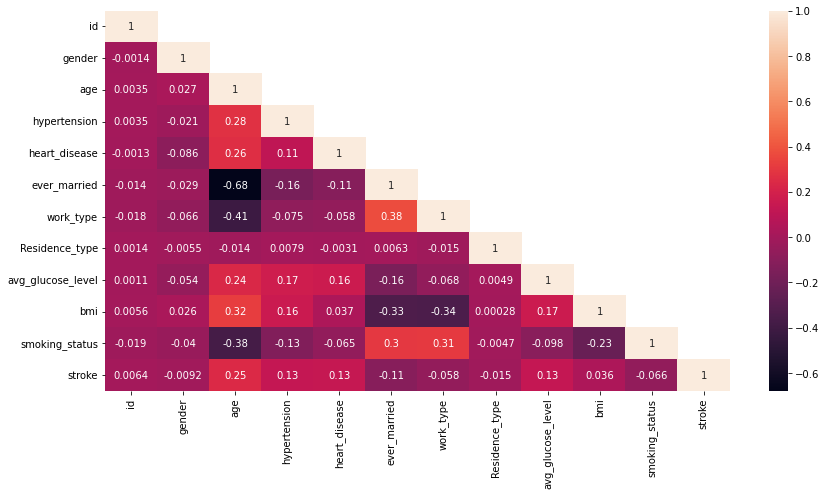

In [9]:
stroke_data['smoking_status'] = pd.factorize(stroke_data['smoking_status'])[0]
stroke_data['work_type'] = pd.factorize(stroke_data['work_type'])[0]
stroke_data['Residence_type'] = pd.factorize(stroke_data['Residence_type'])[0]
stroke_data['ever_married'] = pd.factorize(stroke_data['ever_married'])[0]
stroke_data['gender'] = pd.factorize(stroke_data['gender'])[0]
mask = np.zeros_like(stroke_data.corr())
mask[np.triu_indices_from(mask, 1)] = True
cor = stroke_data.corr()
plt.figure(figsize=(14,7))
sns.heatmap(cor,mask=mask,annot=True)
plt.show()

### 2.6 Checking class distribution


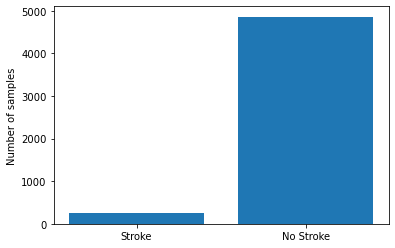

In [10]:
stroke_count =  stroke_data['stroke'].sum()
x = ['Stroke','No Stroke']
y = [stroke_count,len(stroke_data)-stroke_count]
plt.bar(x,y)
plt.ylabel('Number of samples')
plt.show()

## 3. Training a ML model (Decision Tree and SVM)

In [11]:
def show_classification_report(y_true,y_pred,title):
    cf = confusion_matrix(y_true,y_pred)
    df = pd.DataFrame(classification_report(y_true,y_pred,output_dict=True))
    display(df.transpose())
    sns.heatmap(data=cf,cmap=plt.cm.Oranges,annot=True,fmt='d')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

###  3.1 Train-Test Split (3:1)

In [12]:
stroke_x = stroke_data[['age','hypertension','heart_disease','ever_married','avg_glucose_level']]
stroke_y = stroke_data['stroke']
x_train, x_valid, y_train, y_valid = train_test_split(stroke_x, stroke_y, test_size=0.2, random_state=42,shuffle=True)

### 3.2 Training a SVM model with unbalanced dataset

### <u> 3.2.1 Training </u>

In [13]:
#SVM
model = svm.SVC(kernel='poly',probability=True)
model.fit(x_train,y_train.squeeze())
train_predictions = model.predict(x_train)
valid_predictions = model.predict(x_valid)
print('Training accuracy is {:2f}'.format(accuracy_score(y_train,train_predictions)))
print('Training F1_score f1_score is {:2f}'.format(f1_score(y_train,train_predictions)))
print('Validation accuracy is {:2f}'.format(accuracy_score(y_valid,valid_predictions)))
print('Validation F1_score is {:2f}'.format(f1_score(y_valid,valid_predictions)))


Training accuracy is 0.954256
Training F1_score f1_score is 0.000000
Validation accuracy is 0.939335
Validation F1_score is 0.000000


### <u> 3.2.2 Validation </u>

,precision,recall,f1-score,support
0,0.939335,1.000000,0.968718,960.000000
1,0.000000,0.000000,0.000000,62.000000
accuracy,0.939335,0.939335,0.939335,0.939335
macro avg,0.469667,0.500000,0.484359,1022.000000
weighted avg,0.882350,0.939335,0.909951,1022.000000


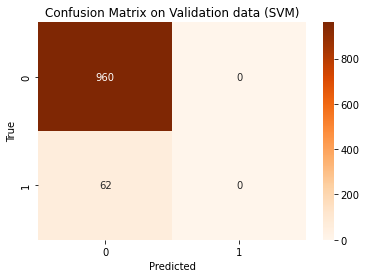

In [14]:
show_classification_report(y_valid,valid_predictions,'Confusion Matrix on Validation data (SVM)')

### 3.3 Training a Decision Tree model with unbalanced dataset

### <u> 3.3.1 Training </u>

In [15]:
#Decision Tree
model = DT()
model.fit(x_train,y_train)
train_predictions = model.predict(x_train)
valid_predictions = model.predict(x_valid)
print('Training accuracy is {:2f}'.format(accuracy_score(y_train,train_predictions)))
print('Training F1_score f1_score is {:2f}'.format(f1_score(y_train,train_predictions,average='micro')))
print('Validation accuracy is {:2f}'.format(accuracy_score(y_valid,valid_predictions)))
print('Validation F1_score is {:2f}'.format(f1_score(y_valid,valid_predictions,average='micro')))

Training accuracy is 1.000000
Training F1_score f1_score is 1.000000
Validation accuracy is 0.919765
Validation F1_score is 0.919765


### <u> 3.3.2 Validation </u>

,precision,recall,f1-score,support
0,0.947047,0.968750,0.957775,960.000000
1,0.250000,0.161290,0.196078,62.000000
accuracy,0.919765,0.919765,0.919765,0.919765
macro avg,0.598523,0.565020,0.576927,1022.000000
weighted avg,0.904760,0.919765,0.911567,1022.000000


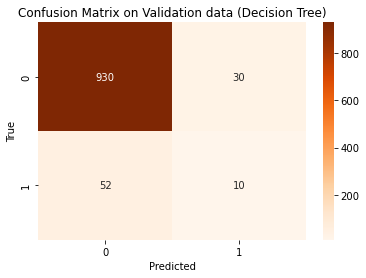

In [16]:
show_classification_report(y_valid,valid_predictions,'Confusion Matrix on Validation data (Decision Tree)')

### 3.4 Addressing class imabalance with SMOTE (OverSampling)

In [17]:
x_train_trans, x_valid_trans, y_train_trans, y_valid_trans = train_test_split(stroke_x, stroke_y, test_size=0.2, random_state=42)
over = SMOTE()
X_transformed, y_transformed = over.fit_resample(x_train_trans,y_train_trans)
Xv_transformed, yv_transformed = over.fit_resample(x_valid_trans,y_valid_trans)

x_train,y_train,x_valid,y_valid = X_transformed,y_transformed,Xv_transformed,yv_transformed


In [18]:
print('Positive examples (stroke) with SMOTE is: {}'.format(y_transformed.sum()))
print('Negative examples (non-stroke) with SMOTE is: {}'.format(len(y_transformed)-y_transformed.sum()))

print('Positive examples (stroke) without SMOTE is: {}'.format(y_train_trans.sum()))
print('Negative examples (non-stroke) without SMOTE is: {}'.format(len(y_train_trans)-y_train_trans.sum()))

Positive examples (stroke) with SMOTE is: 3901
Negative examples (non-stroke) with SMOTE is: 3901
Positive examples (stroke) without SMOTE is: 187
Negative examples (non-stroke) without SMOTE is: 3901


### 3.5 Training SVM with oversampled dataset

### <u> 3.5.1 Training </u>

In [19]:
#SVM
model = svm.SVC(kernel='poly',probability=True)
model.fit(x_train,y_train.squeeze())
train_predictions = model.predict(x_train)
valid_predictions = model.predict(x_valid)
print('Training accuracy is {:2f}'.format(accuracy_score(y_train,train_predictions)))
print('Training F1_score f1_score is {:2f}'.format(f1_score(y_train,train_predictions)))
print('Validation accuracy is {:2f}'.format(accuracy_score(y_valid,valid_predictions)))
print('Validation F1_score is {:2f}'.format(f1_score(y_valid,valid_predictions)))


Training accuracy is 0.775827
Training F1_score f1_score is 0.774584
Validation accuracy is 0.744792
Validation F1_score is 0.731360


### <u> 3.5.2 Validation </u>

,precision,recall,f1-score,support
0,0.722538,0.794792,0.756944,960.000000
1,0.771991,0.694792,0.731360,960.000000
accuracy,0.744792,0.744792,0.744792,0.744792
macro avg,0.747264,0.744792,0.744152,1920.000000
weighted avg,0.747264,0.744792,0.744152,1920.000000


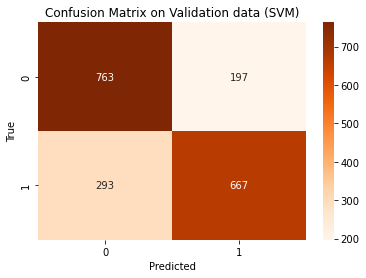

In [20]:
show_classification_report(y_valid,valid_predictions,'Confusion Matrix on Validation data (SVM)')

### 3.6 Training Decision Tree with oversampled dataset

### <u> 3.6.1 Training </u>

In [21]:
#Decision Tree
model = DT()
model.fit(x_train,y_train)
train_predictions = model.predict(x_train)
valid_predictions = model.predict(x_valid)
print('Training accuracy is {:2f}'.format(accuracy_score(y_train,train_predictions)))
print('Training F1_score f1_score is {:2f}'.format(f1_score(y_train,train_predictions,average='micro')))
print('Validation accuracy is {:2f}'.format(accuracy_score(y_valid,valid_predictions)))
print('Validation F1_score is {:2f}'.format(f1_score(y_valid,valid_predictions,average='micro')))

Training accuracy is 1.000000
Training F1_score f1_score is 1.000000
Validation accuracy is 0.798438
Validation F1_score is 0.798438


### <u> 3.6.2 Validation </u>

,precision,recall,f1-score,support
0,0.735029,0.933333,0.822396,960.000000
1,0.908702,0.663542,0.767008,960.000000
accuracy,0.798438,0.798438,0.798438,0.798438
macro avg,0.821865,0.798438,0.794702,1920.000000
weighted avg,0.821865,0.798438,0.794702,1920.000000


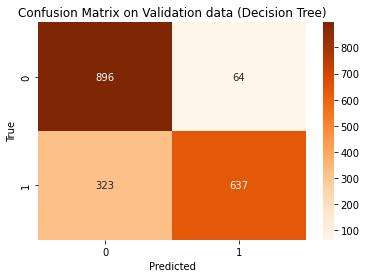

In [22]:
show_classification_report(y_valid,valid_predictions,'Confusion Matrix on Validation data (Decision Tree)')

### 3.7 Addressing class imabalance with SMOTE (UnderSampling)

In [23]:
under = RandomUnderSampler(sampling_strategy=0.5)
X_transformed, y_transformed = under.fit_resample(stroke_x,stroke_y)
x_train, x_valid, y_train, y_valid = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=42,shuffle=True)

### 3.7 Training SVM with undersampled dataset

### <u> 3.7.1 Training </u>

In [24]:
#SVM
model = svm.SVC(kernel='poly',probability=True)
model.fit(x_train,y_train.squeeze())
train_predictions = model.predict(x_train)
valid_predictions = model.predict(x_valid)
print('Training accuracy is {:2f}'.format(accuracy_score(y_train,train_predictions)))
print('Training F1_score f1_score is {:2f}'.format(f1_score(y_train,train_predictions)))
print('Validation accuracy is {:2f}'.format(accuracy_score(y_valid,valid_predictions)))
print('Validation F1_score is {:2f}'.format(f1_score(y_valid,valid_predictions)))


Training accuracy is 0.728643
Training F1_score f1_score is 0.544944
Validation accuracy is 0.753333
Validation F1_score is 0.463768


### <u> 3.7.2 Validation </u>

,precision,recall,f1-score,support
0,0.782258,0.906542,0.839827,107.000000
1,0.615385,0.372093,0.463768,43.000000
accuracy,0.753333,0.753333,0.753333,0.753333
macro avg,0.698821,0.639318,0.651797,150.000000
weighted avg,0.734421,0.753333,0.732023,150.000000


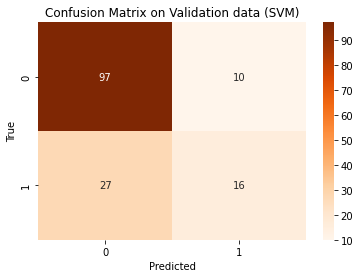

In [25]:
show_classification_report(y_valid,valid_predictions,'Confusion Matrix on Validation data (SVM)')

### 3.8 Training Decision Tree with undersampled dataset

### 3.8.1 <u> Training </u>

In [26]:
#Decision Tree
model = DT()
model.fit(x_train,y_train)
train_predictions = model.predict(x_train)
valid_predictions = model.predict(x_valid)
print('Training accuracy is {:2f}'.format(accuracy_score(y_train,train_predictions)))
print('Training F1_score f1_score is {:2f}'.format(f1_score(y_train,train_predictions,average='micro')))
print('Validation accuracy is {:2f}'.format(accuracy_score(y_valid,valid_predictions)))
print('Validation F1_score is {:2f}'.format(f1_score(y_valid,valid_predictions,average='micro')))

Training accuracy is 1.000000
Training F1_score f1_score is 1.000000
Validation accuracy is 0.653333
Validation F1_score is 0.653333


### <u> 3.8.2 Validation </u>

,precision,recall,f1-score,support
0,0.777778,0.719626,0.747573,107.000000
1,0.411765,0.488372,0.446809,43.000000
accuracy,0.653333,0.653333,0.653333,0.653333
macro avg,0.594771,0.603999,0.597191,150.000000
weighted avg,0.672854,0.653333,0.661354,150.000000


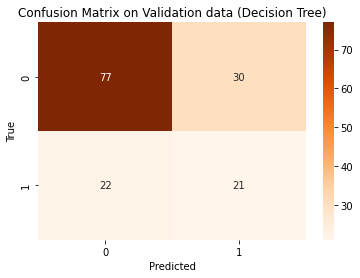

In [27]:
show_classification_report(y_valid,valid_predictions,'Confusion Matrix on Validation data (Decision Tree)')

<b> Inference: </b> <br>
    1. Models trained using processed (no-sampling) dataset are prone to class biased predictions, because of class imbalance. <br>
    2. SVM performs well both on oversampled and undersampled dataset, when compared with Decision Tree.<br>
    3. To tune the model the SVM can be trained using different hyperparameters like kernel type, order of polynomial(if kernel= polynomial),etc,... 